In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyproj import Proj
proj_stere = Proj('epsg:3031')

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter as gf

%matplotlib inline

In [2]:
# Load the data
dat = loadmat('./data/20200104_03_pulse_compressed.mat')
img = 2
data = np.squeeze(dat['data'][0][img])

# Get the time vector and crop the bottom
twtt = np.squeeze(dat['hdr'][0][0][13][0][img])
twtt = twtt[:1100]

# Get a distance vector from the lat/long
lat = dat['hdr']['records'][0][0][img][0][0][0][7]
long = dat['hdr']['records'][0][0][img][0][0][0][8]
x,y = proj_stere(long,lat)
dist = np.cumsum(np.sqrt((np.diff(x))**2.+(np.diff(y))**2.))
dist = np.insert(dist,0,0)
good_traces = np.squeeze(np.argwhere(np.gradient(dist)>.15))

# Crop the bottom of the image and only take traces of increasing distance
data_full = data[:1100,good_traces]

In [3]:
# Take a subset of the image for faster processing
trace1 = 35000
trace2 = 36000
data_sub = data_full[:,trace1:trace2]
tnum = len(data_sub[0])
snum = len(data_sub[:,0])

Text(0.5, 1.0, 'Subset of Image')

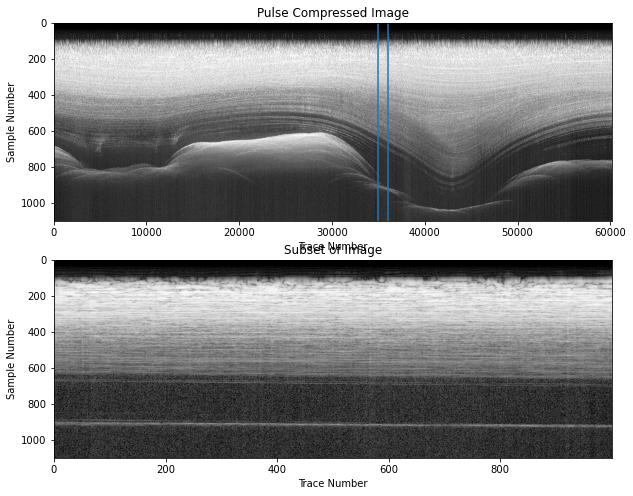

In [4]:
from losar.lib.supplemental import dB

# Plot the full image and the subset

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.imshow(np.real(dB(data_full)),aspect='auto',cmap='Greys_r',vmin=-100,vmax=-70)
plt.axvline(trace1)
plt.axvline(trace2)
plt.ylabel("Sample Number")
plt.xlabel("Trace Number")
plt.title('Pulse Compressed Image')

plt.subplot(212)
plt.imshow(np.real(dB(data_full[:,trace1:trace2])),aspect='auto',cmap='Greys_r',vmin=-100,vmax=-70)
plt.ylabel("Sample Number")
plt.xlabel("Trace Number")
plt.title('Subset of Image')

/Users/benhills/anaconda3/envs/pygmt/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(-2.0408163265306123, 2.036734693877551)

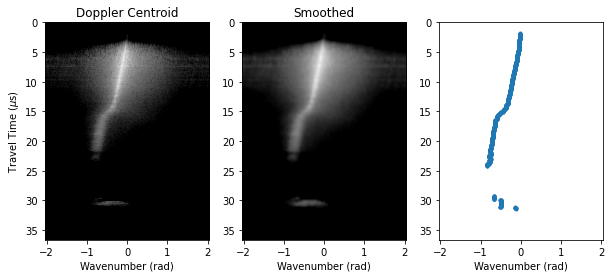

In [5]:
# Find the layer slopes within the image subset using doppler centroid

from losar.lib.sar_functions import losar_doppler
p_dop,f_dop = losar_doppler(data_sub,dx=.245)
p_smooth = gf(p_dop,[5,5])

# Plot the periodograms across all depths
plt.figure(figsize=(10,4))
ax1 = plt.subplot(131)
plt.imshow(dB(p_dop),cmap='Greys_r',vmin=-190,vmax=-130,aspect='auto',
          extent=[min(f_dop),max(f_dop),max(twtt*1e6),min(twtt*1e6)])
plt.xlabel('Wavenumber (rad)')
plt.ylabel('Travel Time ($\mu$s)')
plt.title('Doppler Centroid')

# Same plot but smoothed
ax2 = plt.subplot(132,sharey=ax1)
plt.imshow(dB(p_smooth),cmap='Greys_r',vmin=-190,vmax=-130,aspect='auto',
          extent=[min(f_dop),max(f_dop),max(twtt*1e6),min(twtt*1e6)])
plt.xlabel('Wavenumber (rad)')
plt.title('Smoothed')

# Find and plot the "optimal" wavenumbers (slopes) for each depth
from losar.lib.sar_functions import get_optimal_wavenumbers
p_best,f_best = get_optimal_wavenumbers(p_smooth,f_dop)
ax3 = plt.subplot(133,sharey=ax1)
plt.plot(f_best,twtt*1e6,'.')
plt.xlabel('Wavenumber (rad)')
plt.xlim(min(f_dop),max(f_dop))

In [6]:
# Same as above but by stacking at a set of angles rather than by fourier transform
from losar.lib.sar_functions import losar_stack

phis = np.linspace(-np.pi,np.pi,100)
p_stack = losar_stack(data_sub,phis)
p_smooth = gf(p_stack,[1,1])

p_best,f_best = get_optimal_wavenumbers(p_stack,phis)

(-2.0408163265306123, 2.036734693877551)

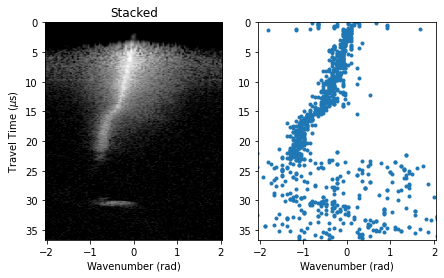

In [7]:
# Plot the result from the stacking method

plt.figure(figsize=(7,4))
ax1 = plt.subplot(121)
plt.imshow(np.real(dB(p_stack)),cmap='Greys_r',vmin=-80,vmax=-50,aspect='auto',
          extent=[min(f_dop),max(f_dop),max(twtt*1e6),min(twtt*1e6)])
plt.xlabel('Wavenumber (rad)')
plt.ylabel('Travel Time ($\mu$s)')
plt.title('Stacked')

ax2 = plt.subplot(122,sharey=ax1)
plt.plot(f_best,twtt*1e6,'.')
plt.xlabel('Wavenumber (rad)')
plt.xlim(min(f_dop),max(f_dop))

In [8]:
# Full LoSAR processing for the image subset

from losar.lib.losar import losar

layer_finding='doppler' # processing algorithm
N = 100 # aperture size
dx = .245 # trace separation

losar_image = losar(data_sub,100,dx=dx)

/Users/benhills/anaconda3/envs/pygmt/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


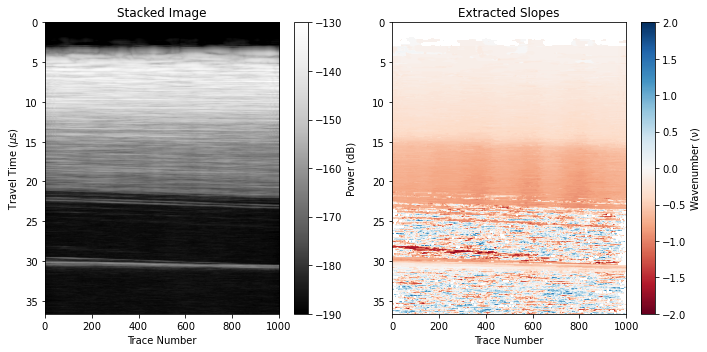

In [9]:
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
plt.imshow(np.real(dB(losar_image[0])),cmap='Greys_r',vmin=-190,vmax=-130,aspect='auto',
          extent=[0,tnum,max(twtt*1e6),min(twtt*1e6)])
plt.ylabel('Travel Time ($\mu$s)')
plt.xlabel('Trace Number')
plt.title('Stacked Image')
plt.colorbar(label='Power (dB)')

ax2 = plt.subplot(122,sharey=ax1)
plt.imshow(np.real(losar_image[1]),cmap='RdBu',vmin=-2,vmax=2,aspect='auto',
          extent=[0,tnum,max(twtt*1e6),min(twtt*1e6)])
plt.title('Extracted Slopes')
plt.xlabel('Trace Number')
plt.colorbar(label='Wavenumber (ν)')

plt.tight_layout()